# <b>1. Model setup</b>

In [1]:
import os

# Download model weight
if not os.path.exists('yolov7.pt'):
  # Download model weight
  ! wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt -O yolov7.pt

# Create the model
from traffic_detector import TrafficDetector
detector = TrafficDetector()
detector.set_conf('weights', 'yolov7.pt')
detector.setup_model()

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 


/Applications/anaconda3/envs/yolov7/lib/python3.11/site-packages/torch/nn/modules/module.py:831: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:491.)
  if param.grad is not None:


 traced_script_module saved! 
 model is traced! 



# <b>2. Test on one image</b>

/Applications/anaconda3/envs/yolov7/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


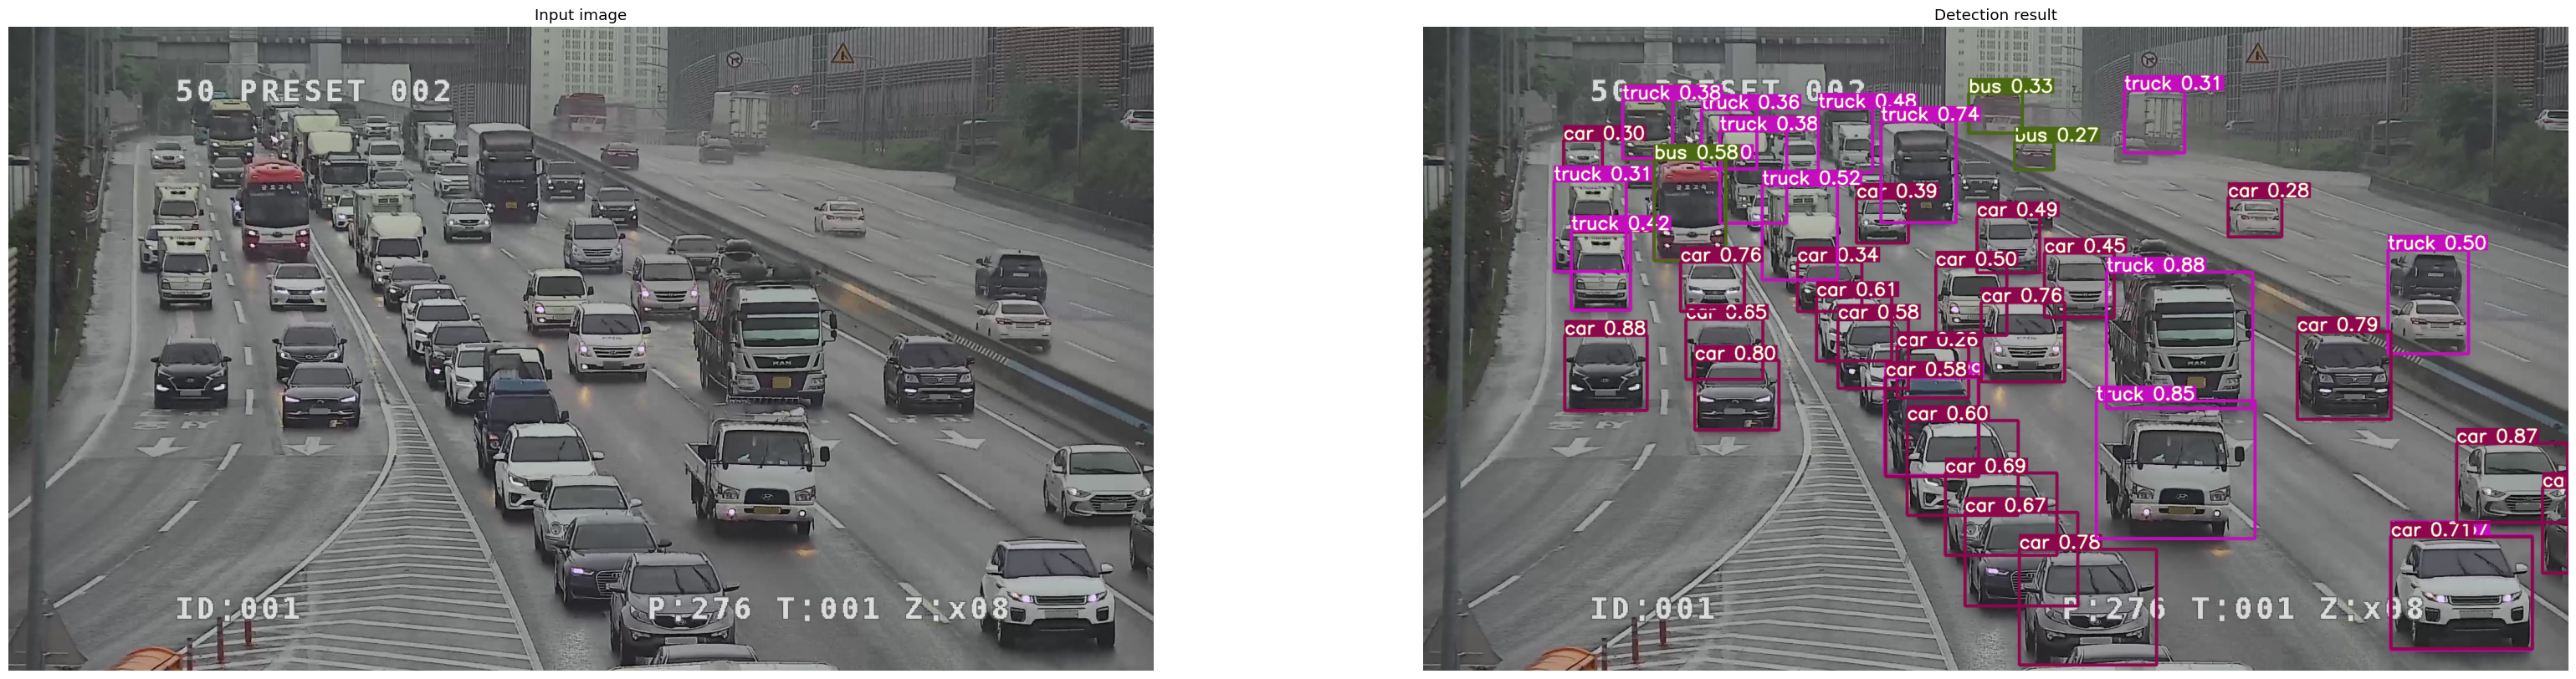

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams["figure.figsize"] = (40,10)


img = cv2.imread('data/vehicle_test.png')
output=detector.detect(img, sdf, s,)
# cv2.imread: BGR -> plt.imshow(rgb)
plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.title('Input image')
plt.axis('off')

plt.subplot(122)
plt.imshow(output[:,:,::-1])
plt.title('Detection result')
plt.axis('off')
plt.show()

# <b>3. Test on a video</b>

You can click on the button to switch between diplaying the original video frame and the detection results.

ToggleButton(value=False, button_style='danger', description='Vehicle Detection', icon='square', tooltip='Desc…

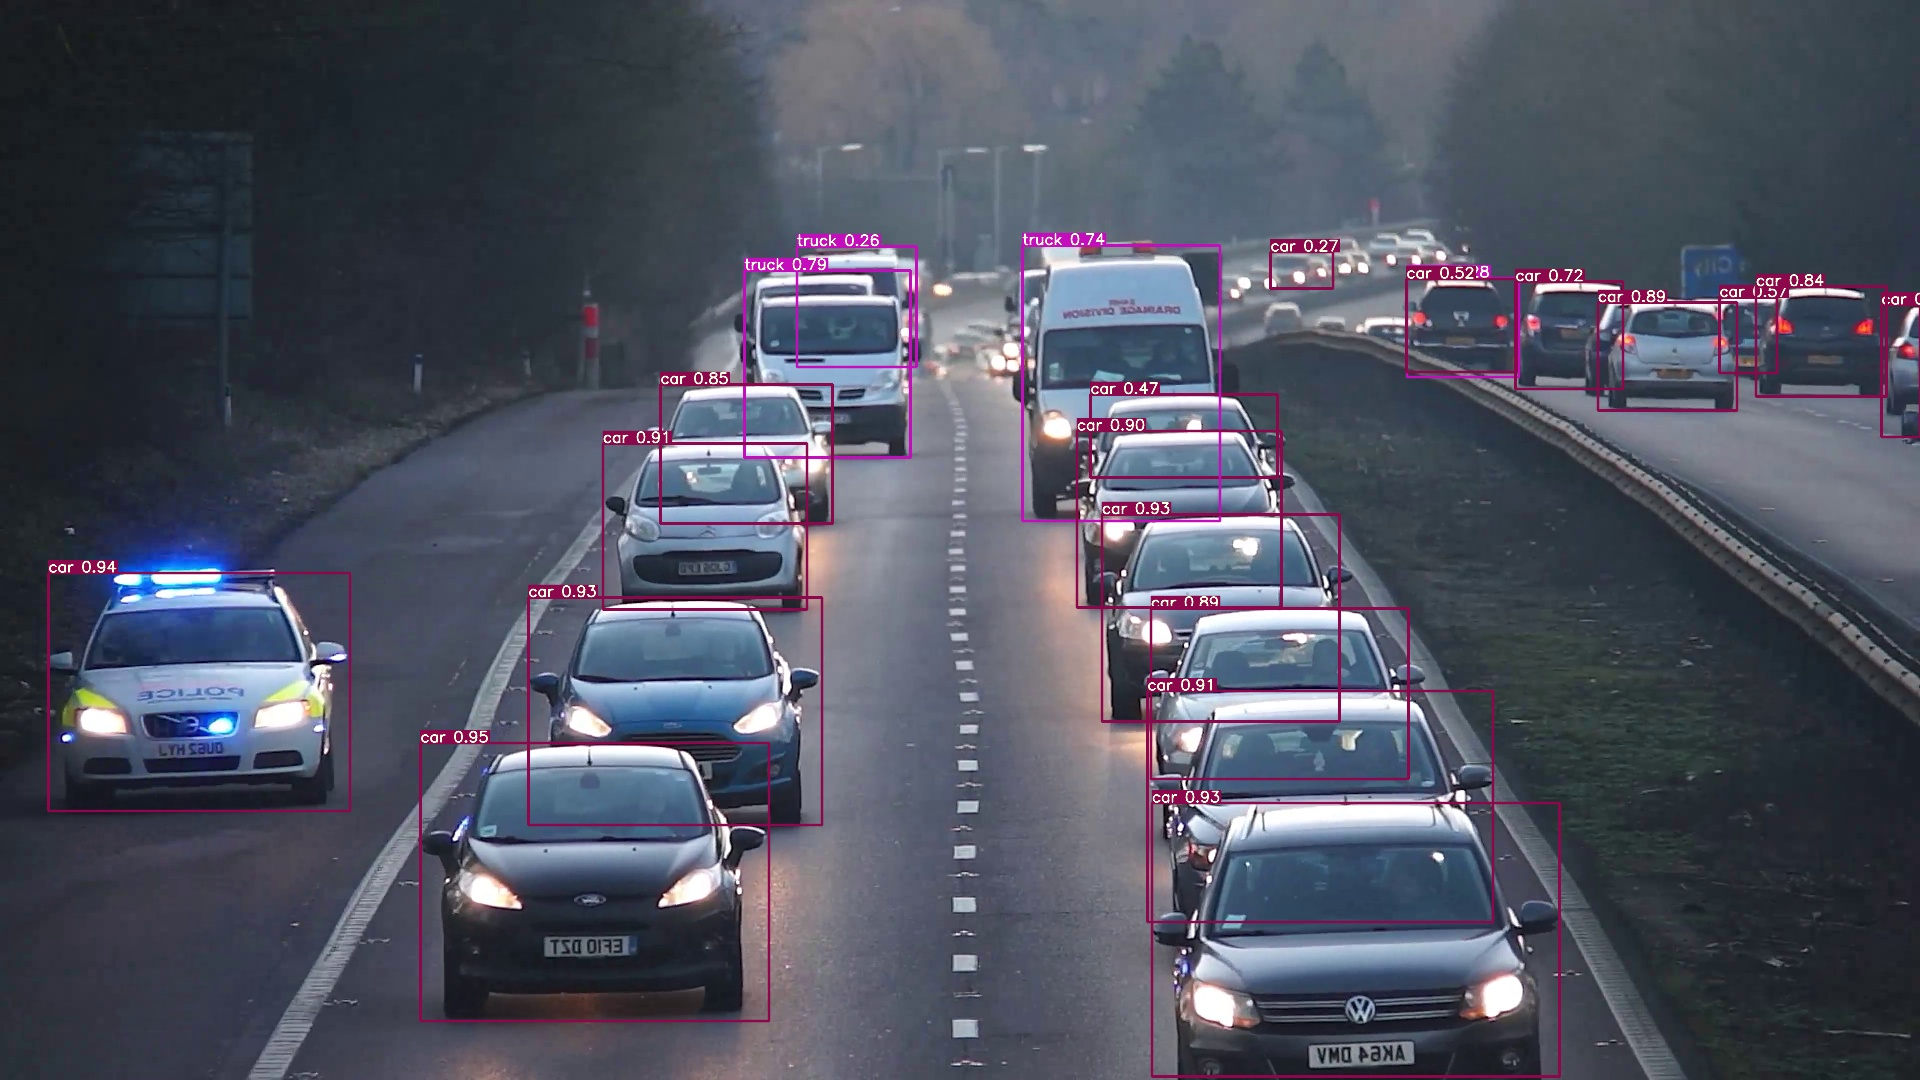

In [9]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading

# Detect button
# ================
detect_button = widgets.ToggleButton(
    value=False,
    description='Vehicle Detection',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)


# Display function
# ================
def view(button, video_source):
    cap = cv2.VideoCapture(video_source)
    display_handle=display(None, display_id=True)
    i = 0
    while True:
        _, frame = cap.read()
        frame = cv2.flip(frame, 1) # if your camera reverses your image
        if detect_button.value==True:
            # do detection
            frame = detector.detect(frame, output_ratio=2)
            button.description = 'Original Frame'
        else:
            button.description = 'Vehicle Detection'
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
                
    # close the video and the display
    cap.release()
    display_handle.update(None)

            
# Run
# ================
display(detect_button)
video_source = 'data/vehicle_test.mp4'
thread = threading.Thread(target=view, args=(detect_button, video_source))
thread.start()

# <b>4. Test on Live camera stream</b>

In [6]:
!pip install --force-reinstall git+https://github.com/ytdl-org/youtube-dl.git@master
!pip install --force-reinstall git+https://github.com/donglaiw/pafy.git@develop

  Cloning https://github.com/ytdl-org/youtube-dl.git (to revision master) to /private/var/folders/g_/dv1mfxkx7yv0f7dmb3l6qdhr0000gn/T/pip-req-build-qppj0o06
  Running command git clone --filter=blob:none --quiet https://github.com/ytdl-org/youtube-dl.git /private/var/folders/g_/dv1mfxkx7yv0f7dmb3l6qdhr0000gn/T/pip-req-build-qppj0o06
  Resolved https://github.com/ytdl-org/youtube-dl.git to commit d1c6c5c4d618fa950813c0c71aede34a5ac851e9
  Preparing metadata (setup.py) ... done
  Created wheel for youtube-dl: filename=youtube_dl-2021.12.17-py2.py3-none-any.whl size=1921851 sha256=e4802e4beca966f5cbeb697e59de74728e48dd43d61922067caac99ea20321af
  Stored in directory: /private/var/folders/g_/dv1mfxkx7yv0f7dmb3l6qdhr0000gn/T/pip-ephem-wheel-cache-cjo6nrvd/wheels/47/69/07/ebbefe9d68d151fa949aef854ba322e8a43878d24cc7205ec6
Successfully built youtube-dl
  Attempting uninstall: youtube-dl
    Found existing installation: youtube-dl 2021.12.17
    Uninstalling youtube-dl-2021.12.17:
      Succes

ToggleButton(value=False, button_style='danger', description='Original Frame', icon='square', tooltip='Descrip…

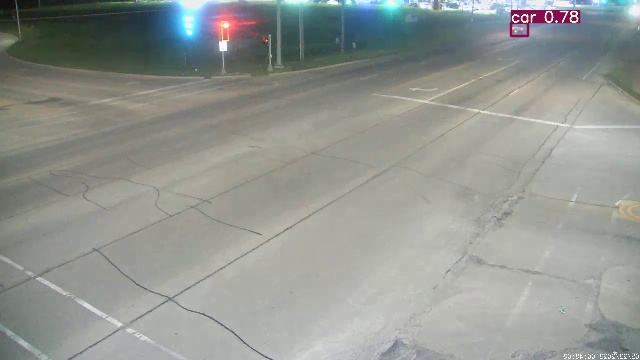

[tls @ 0x7f9bd1548000] Error in the pull function.
[tls @ 0x7f9bd1548000] IO error: End of file
[tls @ 0x7f9be32a1a40] Error in the pull function.
[tls @ 0x7f9be32a1a40] IO error: End of file
[tls @ 0x7f9c70ec4300] Error in the pull function.
[tls @ 0x7f9c70ec4300] IO error: End of file


In [8]:
import pafy

# get live traffic camera source
url = "https://youtu.be/5_XSYlAfJZM"
video = pafy.new(url)
best = video.getbest(preftype="mp4")


# Run
# ================
video_source = best.url
display(detect_button)
thread = threading.Thread(target=view, args=(detect_button, video_source))
thread.start()